# Data Cleaning Pipeline

In [12]:
# Only need to assign the two values below first, then run all
watershed = 'CentralArizona'
main_str = 'SCNFM'

In [13]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/8-CentralArizona/DailyData'

In [14]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [15]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        0.0   
1915-11-02              NaN                        NaN   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       0.0   
1915-11-02                          NaN                       NaN   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                      0.0                       0.0   
1915-11-02                      NaN                       NaN   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          0.0  
1915-11-02                          NaN

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
2008-03-20         141.5840                        NaN   
2008-03-21         113.2672                        NaN   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
2008-03-20                          NaN                       NaN   
2008-03-21                          NaN                       NaN   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
2008-03-20                      NaN                       NaN   
2008-03-21                      NaN                       NaN   

            Sunflower3NNW_Precipitation  
DateTime                                 
2008-03-20                          NaN  
2008-03-21                          NaN

In [16]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['SCNFM' 'BartlettDam' 'FountainHills' 'MormonFlat' 'PunkinCtr'
 'StewartMtn' 'Sunflower3NNW']
  
Discharge stations : ['SCNFM']
  
Meteorology stations: ['BartlettDam', 'FountainHills', 'MormonFlat', 'PunkinCtr', 'StewartMtn', 'Sunflower3NNW']


In [17]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

SCNFM_Discharge


In [18]:
len(nameHydrMetStation)

6

#  1. Trim the original table

In [19]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        0.0   
1915-11-02              NaN                        NaN   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       0.0   
1915-11-02                          NaN                       NaN   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                      0.0                       0.0   
1915-11-02                      NaN                       NaN   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          0.0  
1915-11-02                          NaN

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
2008-03-20         141.5840                        NaN   
2008-03-21         113.2672                        NaN   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
2008-03-20                          NaN                       NaN   
2008-03-21                          NaN                       NaN   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
2008-03-20                      NaN                       NaN   
2008-03-21                      NaN                       NaN   

            Sunflower3NNW_Precipitation  
DateTime                                 
2008-03-20                          NaN  
2008-03-21                          NaN

trimmed row number is  0


### Drop columns without data

In [20]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [21]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

0 SCNFM_Discharge index of interpolated length = 3
No filled values are out of original data range
 
1 BartlettDam_Precipitation index of interpolated length = 429
No filled values are out of original data range
 
2 FountainHills_Precipitation index of interpolated length = 79
No filled values are out of original data range
 
3 MormonFlat_Precipitation index of interpolated length = 934
No filled values are out of original data range
 
4 PunkinCtr_Precipitation index of interpolated length = 992
No filled values are out of original data range
 
5 StewartMtn_Precipitation index of interpolated length = 122
No filled values are out of original data range
 
6 Sunflower3NNW_Precipitation index of interpolated length = 608
No filled values are out of original data range
 


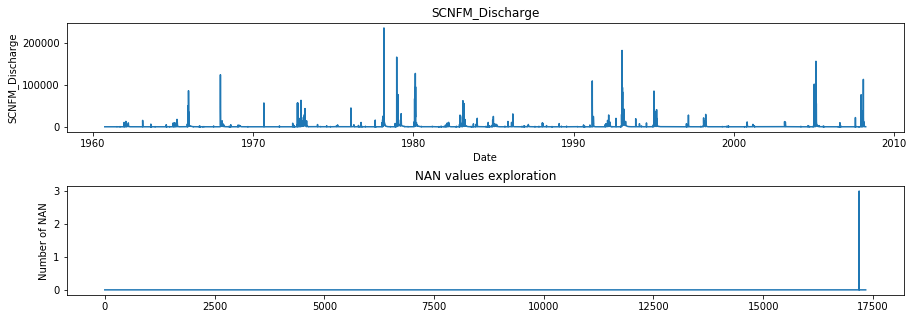

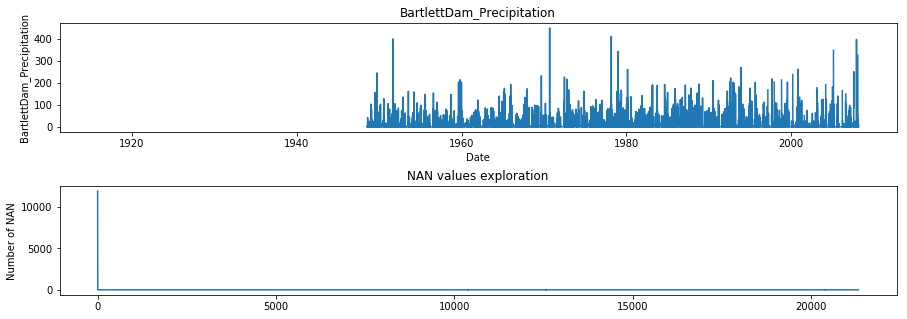

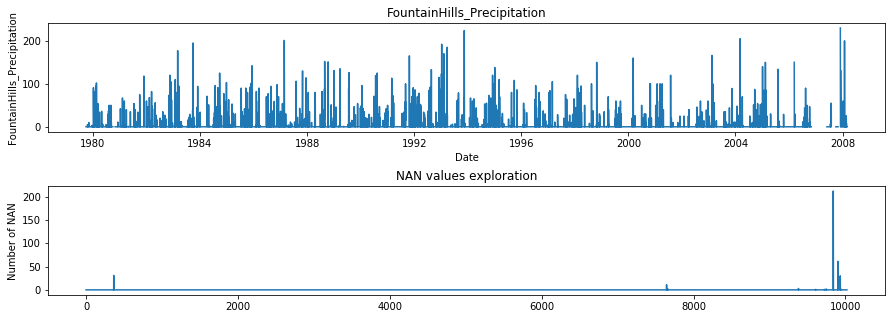

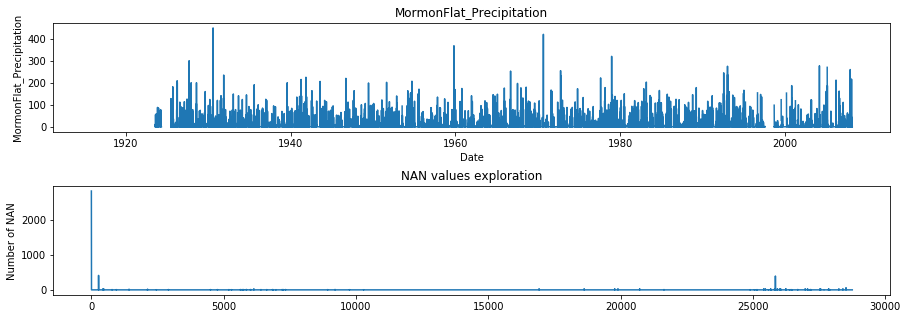

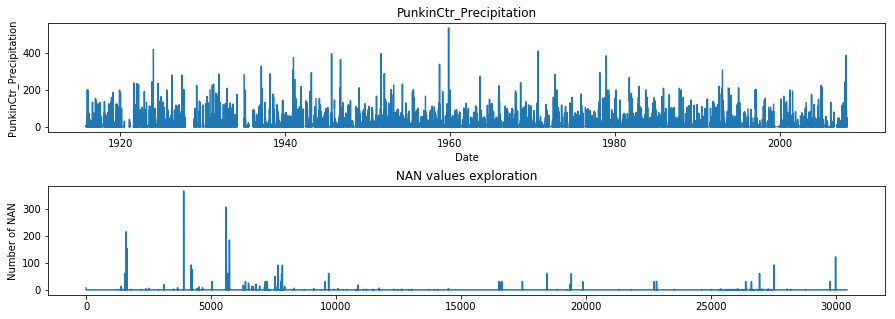

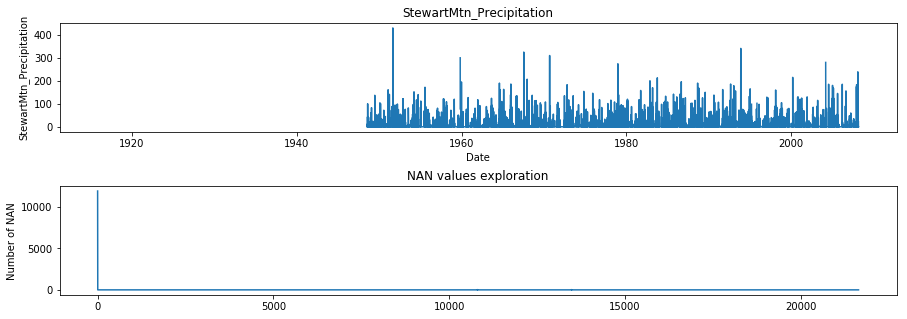

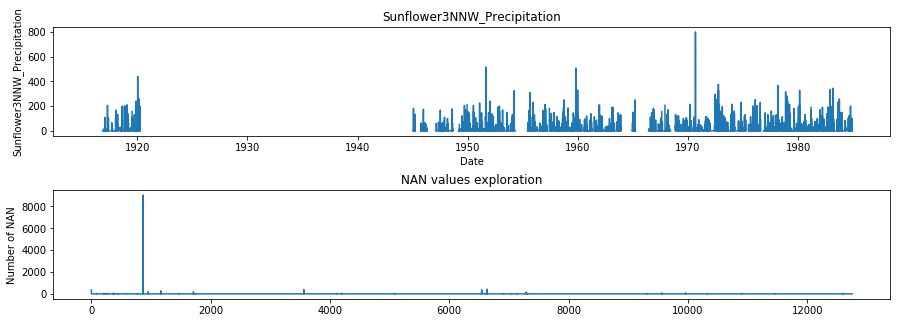

In [22]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [23]:
flag_table2.head(2)

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        1.0   
1915-11-02              NaN                        2.0   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       1.0   
1915-11-02                          NaN                       2.0   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                      1.0                       1.0   
1915-11-02                      2.0                       2.0   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          1.0  
1915-11-02                          2.0

In [24]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [25]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [26]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [27]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation']


True

1 / 7 in process: SCNFM Discharge
 
No Precipitation data at station SCNFM
 
No Discharge data at station BartlettDam
 
2 / 7 in process: BartlettDam Precipitation
 
No Discharge data at station FountainHills
 
3 / 7 in process: FountainHills Precipitation
 
No Discharge data at station MormonFlat
 
4 / 7 in process: MormonFlat Precipitation
 
No Discharge data at station PunkinCtr
 
5 / 7 in process: PunkinCtr Precipitation
 
No Discharge data at station StewartMtn
 
6 / 7 in process: StewartMtn Precipitation
 
No Discharge data at station Sunflower3NNW
 
7 / 7 in process: Sunflower3NNW Precipitation
 
CPU times: user 7.56 s, sys: 308 ms, total: 7.87 s
Wall time: 17.7 s


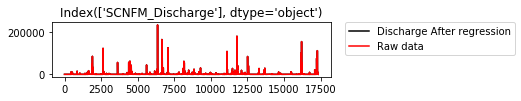

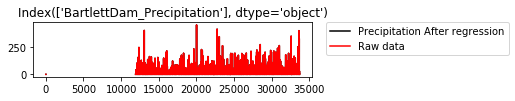

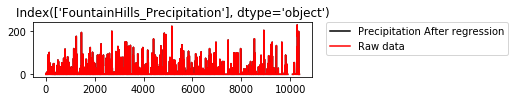

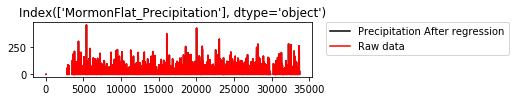

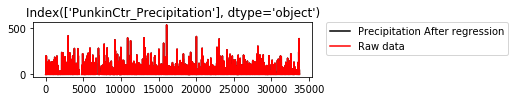

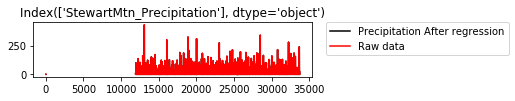

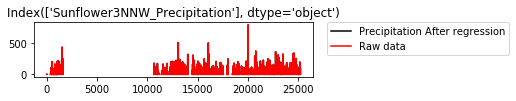

In [28]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [29]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [30]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [31]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [32]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

SCNFM_Discharge
DateTime                   
1915-11-01              NaN
1915-11-02              NaN

In [33]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

0 SCNFM_Discharge 0
1 BartlettDam_Precipitation 50
2 FountainHills_Precipitation 71
3 MormonFlat_Precipitation 387
4 PunkinCtr_Precipitation 866
5 StewartMtn_Precipitation 34
6 Sunflower3NNW_Precipitation 674


In [34]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [35]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [36]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [37]:
table4.head()

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        0.0   
1915-11-02              NaN                        0.0   
1915-11-03              NaN                        0.0   
1915-11-04              NaN                        0.0   
1915-11-05              NaN                        0.0   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       0.0   
1915-11-02                          NaN                       0.0   
1915-11-03                          NaN                       0.0   
1915-11-04                          NaN                       0.0   
1915-11-05                          NaN                       0.0   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                    0.000                  0.000000   
1915-11-02                    0.125                  0.000503   
1915-11-03                    0.250                  0.001006   
1915-11-04                    0.375                  0.001509   
1915-11-05                    0.500                  0.002012   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          0.0  
1915-11-02                          0.0  
1915-11-03                          0.0  
1915-11-04                          0.0  
1915-11-05                          0.0

In [38]:
flag_table4.head()

SCNFM_Discharge  BartlettDam_Precipitation  \
DateTime                                                 
1915-11-01              NaN                        1.0   
1915-11-02              NaN                        2.0   
1915-11-03              NaN                        2.0   
1915-11-04              NaN                        2.0   
1915-11-05              NaN                        2.0   

            FountainHills_Precipitation  MormonFlat_Precipitation  \
DateTime                                                            
1915-11-01                          NaN                       1.0   
1915-11-02                          NaN                       2.0   
1915-11-03                          NaN                       2.0   
1915-11-04                          NaN                       2.0   
1915-11-05                          NaN                       2.0   

            PunkinCtr_Precipitation  StewartMtn_Precipitation  \
DateTime                                                        
1915-11-01                      1.0                       1.0   
1915-11-02                      2.0                       2.0   
1915-11-03                      2.0                       2.0   
1915-11-04                      2.0                       2.0   
1915-11-05                      2.0                       2.0   

            Sunflower3NNW_Precipitation  
DateTime                                 
1915-11-01                          1.0  
1915-11-02                          2.0  
1915-11-03                          2.0  
1915-11-04                          2.0  
1915-11-05                          2.0

In [39]:
table4.shape

(33745, 7)

In [40]:
flag_table4.shape

(33745, 7)